# 跳跃关联动量因子

## 导入模块

In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import feather
import statsmodels.api as sm

## 读入日线数据

### 日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')
price_1d = price_1d[(price_1d['date'] >= '2019-01-01') & (price_1d['date'] <= '2024-12-31')]

## 计算过去 20 天收益率

In [25]:
%%time
price_1d['ret_plus'] = 1 + price_1d['ret']
price_1d['ret_20'] = (
    price_1d
        .groupby('issue')['ret_plus']
        .transform(lambda x: x.rolling(20).apply(np.prod, raw=True) - 1)
)
price_1d = price_1d.drop(columns='ret_plus')

CPU times: total: 26 s
Wall time: 26.4 s


## 跳跃关联动量

### 读入相关性 & 矩阵展平 & 稀疏化处理

In [113]:
def get_correlation(date: str):
    date_pd = pd.to_datetime(date)
    date_str = date_pd.strftime('%Y%m%d')
    corr = feather.read_dataframe(f'../data/corr/corr_num_{date_str}.feather')
    np.fill_diagonal(corr.values, 0)
    corr = (
        corr
            .stack()
            .rename('corr')
            .rename_axis(['issue_i', 'issue_j'])
    )
    corr = corr.reset_index()
    
    med = corr.loc[corr['corr'] > 0, 'corr'].median()
    corr.loc[corr['corr'] < med, 'corr'] = 0

    return corr

## 计算绝对动量

In [66]:
prc_date = price_1d.loc[price_1d['date'] == date, ['issue', 'ret_20']]
corr_ret = pd.merge(
    corr,
    prc_date,
    left_on='issue_j',
    right_on='issue',
    how='left'
)

In [93]:
%%time

def peer_ret_calc(corr_ret: pd.DataFrame):
    nume = (corr_ret['corr'] * corr_ret['ret_20']).sum()
    deno = corr_ret['corr'].sum()
    if deno == 0:
        return np.nan
    peer_ret = nume / deno
    return peer_ret

peer_ret = (
    corr_ret
        .groupby('issue_i')[['corr', 'ret_20']]
        .apply(peer_ret_calc)
)
peer_ret = peer_ret.dropna()
peer_ret = peer_ret.rename('peer_ret')
peer_ret = peer_ret.rename_axis(index = {'issue_i': 'issue'})
peer_ret = peer_ret.to_frame().reset_index()

peer_ret = pd.merge(
    peer_ret,
    prc_date,
    on='issue',
    how='left'
)
peer_ret = peer_ret.dropna(subset='ret_20')
peer_ret['date'] = date

CPU times: total: 3.12 s
Wall time: 3.19 s


In [94]:
peer_ret

,issue,peer_ret,ret_20,date
0,000001,-0.200617,0.028261,2024-01-31
1,000002,-0.213494,-0.052320,2024-01-31
2,000004,-0.223841,-0.242331,2024-01-31
3,000005,-0.203064,-0.175439,2024-01-31
4,000006,-0.208031,-0.075388,2024-01-31
...,...,...,...,...
5092,688799,-0.214031,-0.223481,2024-01-31
5093,688800,-0.226852,-0.334086,2024-01-31
5094,688819,-0.223211,-0.110631,2024-01-31
5095,688981,-0.225989,-0.175114,2024-01-31


## 计算相对动量

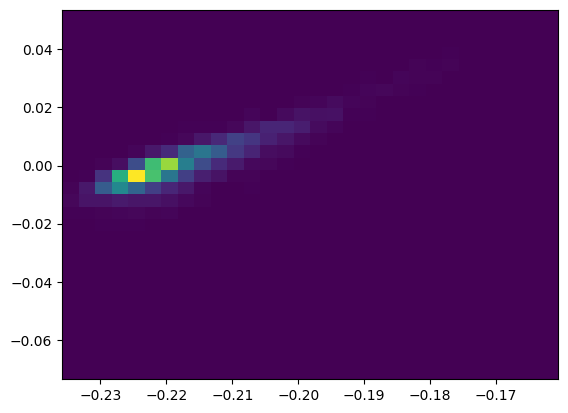

In [106]:
x = peer_ret['ret_20']
x = sm.add_constant(x)
y = peer_ret['peer_ret']
result = sm.OLS(y, x).fit()
peer_ret['peer_relative_ret'] = result.resid
plt.hist2d(y, result.resid, bins=30)
plt.show()